
--- Analyzing DCR data and preparing for plotting ---
{'Timestamp': '2025-05-20 13:53:19', 'Temperature (Â°C)': '10.0', 'Voltage (V)': '64.0', 'Average DCR (Hz)': '80.0', 'SEM (Hz)': '48.98979485566356', 'Threshold (mV)': '75'}
{'Timestamp': '2025-05-20 13:53:19', 'Temperature (Â°C)': '10.0', 'Voltage (V)': '64.25', 'Average DCR (Hz)': '80.0', 'SEM (Hz)': '80.0', 'Threshold (mV)': '75'}
{'Timestamp': '2025-05-20 13:53:19', 'Temperature (Â°C)': '10.0', 'Voltage (V)': '64.5', 'Average DCR (Hz)': '1080.0', 'SEM (Hz)': '1080.0', 'Threshold (mV)': '75'}
{'Timestamp': '2025-05-20 13:53:19', 'Temperature (Â°C)': '10.0', 'Voltage (V)': '64.75', 'Average DCR (Hz)': '40.0', 'SEM (Hz)': '40.0', 'Threshold (mV)': '75'}
{'Timestamp': '2025-05-20 13:53:19', 'Temperature (Â°C)': '10.0', 'Voltage (V)': '65.0', 'Average DCR (Hz)': '0.0', 'SEM (Hz)': '0.0', 'Threshold (mV)': '75'}
{'Timestamp': '2025-05-20 13:53:19', 'Temperature (Â°C)': '10.0', 'Voltage (V)': '65.25', 'Average DCR (Hz)': '1480.0', 'SE

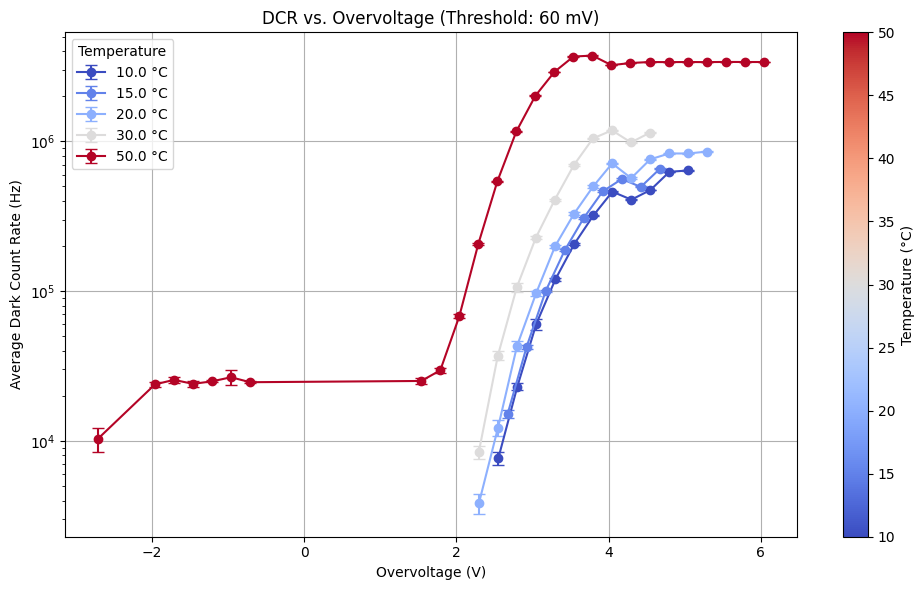

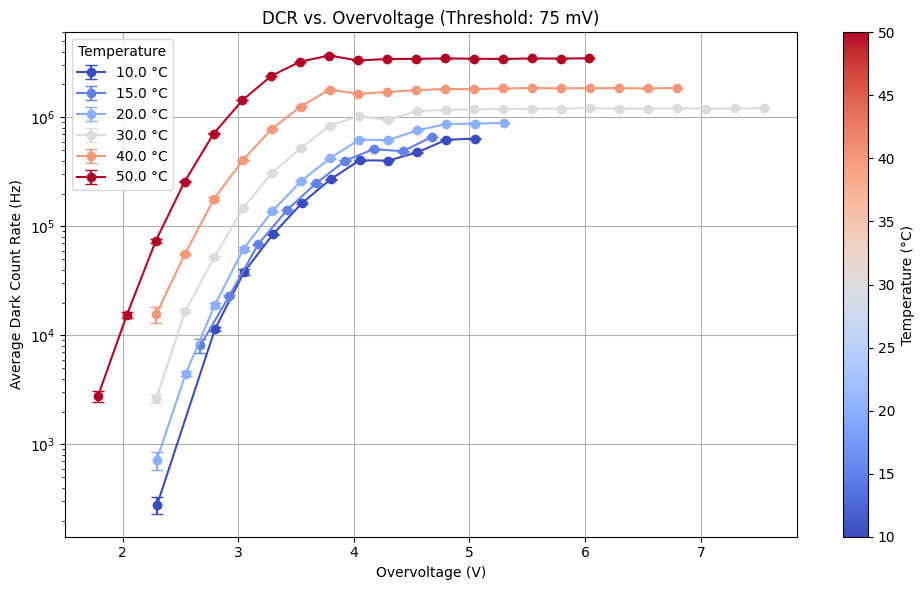

In [8]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# --- Provided Breakdown Voltage Linear Fit Results ---
# We are no longer calculating these, but using the provided values.
# V_BD = a * Temp + b
slope_a = 0.0753
intercept_b = 62.9477

# --- Refactored DCR analysis function (data loading and overvoltage calculation) ---
def analyze_dcr_from_csv(csv_file, vbd_slope, vbd_intercept):
    """
    Analyzes DCR data from a CSV file, calculates overvoltage for all data points.

    Args:
        csv_file (str): Path to the CSV file.
        vbd_slope (float): Slope 'a' from the V_BD vs. Temperature linear fit.
        vbd_intercept (float): Intercept 'b' from the V_BD vs. Temperature linear fit.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              'temperature', 'voltage', 'dcr', 'sem', 'threshold', and 'overvoltage'.
    """
    data_points = []

    with open(csv_file, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            try:
                print(row)
                voltage = float(row['Voltage (V)'])
                dcr = float(row['Average DCR (Hz)'])
                sem = float(row['SEM (Hz)'])
                temperature = float(row['Temperature (Â°C)'])
                threshold = float(row['Threshold (mV)'])

                data_points.append({
                    'temperature': temperature,
                    'voltage': voltage,
                    'dcr': dcr,
                    'sem': sem,
                    'threshold': threshold
                })
            except ValueError as e:
                print(f"Error reading row: {row}. Skipping. Error: {e}")
                continue

    if not data_points:
        print("No valid data found in the CSV file.")
        return []

    # Calculate overvoltage for each data point
    for dp in data_points:
        v_bd_at_temp = vbd_slope * dp['temperature'] + vbd_intercept
        dp['overvoltage'] = dp['voltage'] - v_bd_at_temp

    return data_points

# --- New plotting function with Colormap and Temperature Exclusion ---
def plot_dcr_data_by_threshold_with_colormap(data_points, thresholds_to_plot=None, exclude_temps=None):
    """
    Plots DCR vs. Overvoltage for specified thresholds with a colormap for temperature,
    allowing exclusion of specific temperatures.

    Args:
        data_points (list): List of dictionaries containing DCR data with overvoltage.
        thresholds_to_plot (list, optional): A list of threshold values (in mV)
                                             to plot. If None, plots all unique thresholds.
        exclude_temps (list, optional): A list of temperature values (in °C) to exclude from plotting.
    """
    if not data_points:
        print("No data points provided for plotting.")
        return

    if exclude_temps is None:
        exclude_temps = [] # Ensure it's a list even if not provided

    # Filter out excluded temperatures from the initial data
    filtered_data_points = [dp for dp in data_points if dp['temperature'] not in exclude_temps]

    if not filtered_data_points:
        print("No data points remaining after temperature exclusion.")
        return

    all_unique_thresholds = sorted(list(set(dp['threshold'] for dp in filtered_data_points)))

    if thresholds_to_plot is None:
        selected_thresholds = all_unique_thresholds
    else:
        selected_thresholds = sorted([t for t in thresholds_to_plot if t in all_unique_thresholds])
        if not selected_thresholds:
            print(f"None of the specified thresholds {thresholds_to_plot} found in the filtered data.")
            return

    # Determine the overall temperature range for colormap normalization based on *filtered* data
    all_temperatures = [dp['temperature'] for dp in filtered_data_points]
    if not all_temperatures: # Handle case where all data might be filtered out
        print("No temperatures left to plot after filtering.")
        return

    min_temp = min(all_temperatures)
    max_temp = max(all_temperatures)

    for current_threshold in selected_thresholds:
        plt.figure(figsize=(10, 6))
        ax = plt.gca() # Get current axes for scalar mappable

        # Filter data for the current threshold and for SEM < 20% DCR
        threshold_data_filtered = sorted(
            [dp for dp in filtered_data_points if dp['threshold'] == current_threshold and dp['sem'] < 0.20 * dp['dcr']],
            key=lambda x: x['overvoltage'] # Sort by overvoltage for cleaner lines if plotting connected
        )

        if not threshold_data_filtered:
            print(f"No valid data (SEM < 20% DCR) for threshold {current_threshold} mV to plot.")
            plt.close() # Close empty figure
            continue

        # Get unique temperatures for this threshold to plot distinct lines/points
        temperatures_at_threshold = sorted(list(set(dp['temperature'] for dp in threshold_data_filtered)))

        # Create a colormap
        cmap = plt.get_cmap('coolwarm')
        normalize = plt.Normalize(vmin=min_temp, vmax=max_temp)
        
        # Create a scalar mappable for the colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
        sm.set_array([]) # dummy array for the colorbar

        for temp in temperatures_at_threshold:
            temp_specific_data = [dp for dp in threshold_data_filtered if dp['temperature'] == temp]
            overvoltages_at_temp = [dp['overvoltage'] for dp in temp_specific_data]
            dcr_at_temp = [dp['dcr'] for dp in temp_specific_data]
            sem_at_temp = [dp['sem'] for dp in temp_specific_data]

            if overvoltages_at_temp:
                color = cmap(normalize(temp))
                ax.errorbar(overvoltages_at_temp, dcr_at_temp, yerr=sem_at_temp, 
                            fmt='o-', color=color, capsize=4, label=f'{temp:.1f} °C')

        ax.set_xlabel('Overvoltage (V)')
        ax.set_ylabel('Average Dark Count Rate (Hz)')
        ax.set_title(f'DCR vs. Overvoltage (Threshold: {current_threshold} mV)')
        ax.grid(True)
        ax.set_yscale('log')
        ax.legend(title='Temperature', loc='best')

        # Add colorbar
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Temperature (°C)')

        plt.tight_layout()
        plt.show()

# --- Main Execution ---
if __name__ == '__main__':
    csv_file_path = 'dcr_vs_voltage2.csv'  # Replace with your actual DCR CSV file path
    
    print("\n--- Analyzing DCR data and preparing for plotting ---")
    all_dcr_data = analyze_dcr_from_csv(csv_file_path, slope_a, intercept_b)
    
    print("\n--- Plotting DCR data by threshold with colormap ---")
    
    # Example Usage:
    # Plot for thresholds 60 mV and 75 mV, excluding 5.0 °C data
    plot_dcr_data_by_threshold_with_colormap(all_dcr_data, thresholds_to_plot=[60, 75], exclude_temps=[5.0,60])
    
    # Plot for all unique thresholds, excluding 10.0 °C and 20.0 °C data
    # plot_dcr_data_by_threshold_with_colormap(all_dcr_data, exclude_temps=[10.0, 20.0])

    # Plot for a single threshold (e.g., 60 mV), without excluding any temperatures
    # plot_dcr_data_by_threshold_with_colormap(all_dcr_data, thresholds_to_plot=[60])

Processing IV files and finding breakdown voltages...


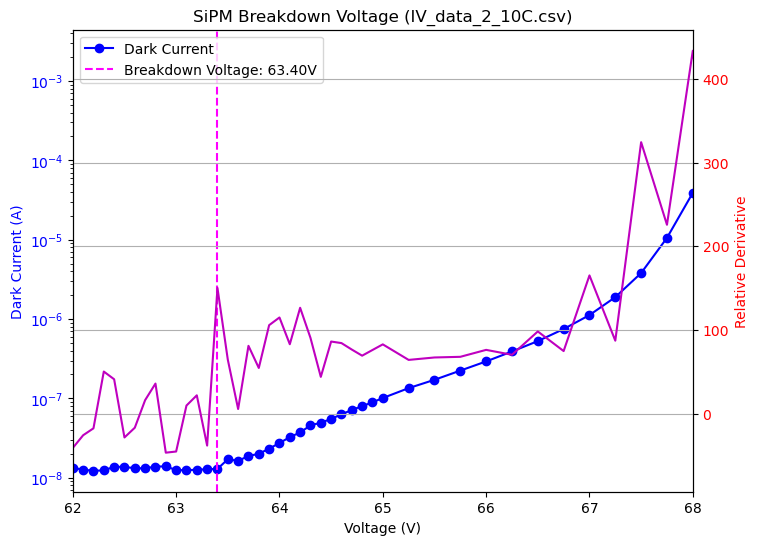

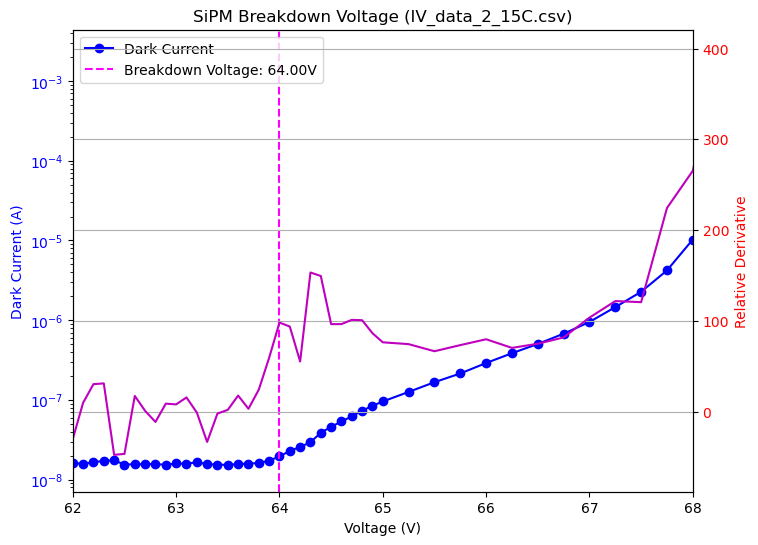

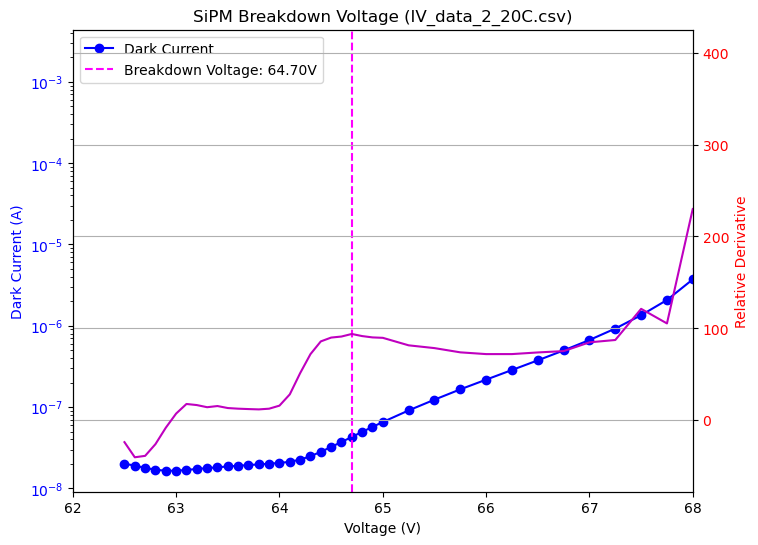

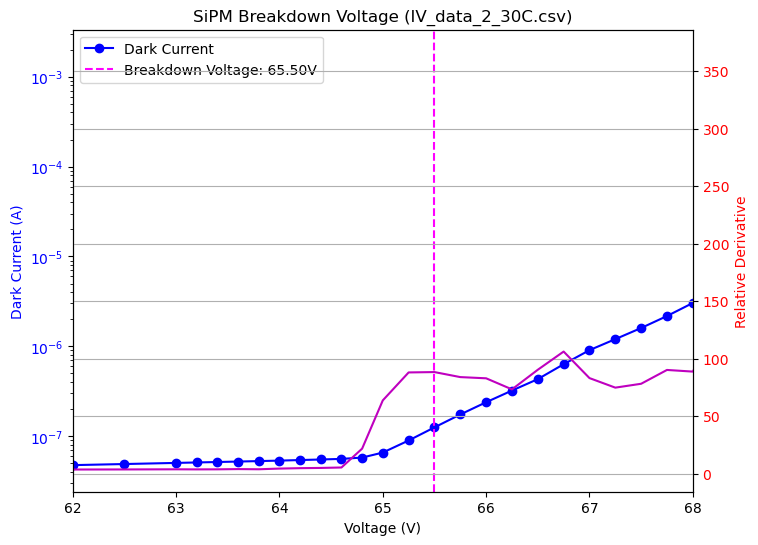

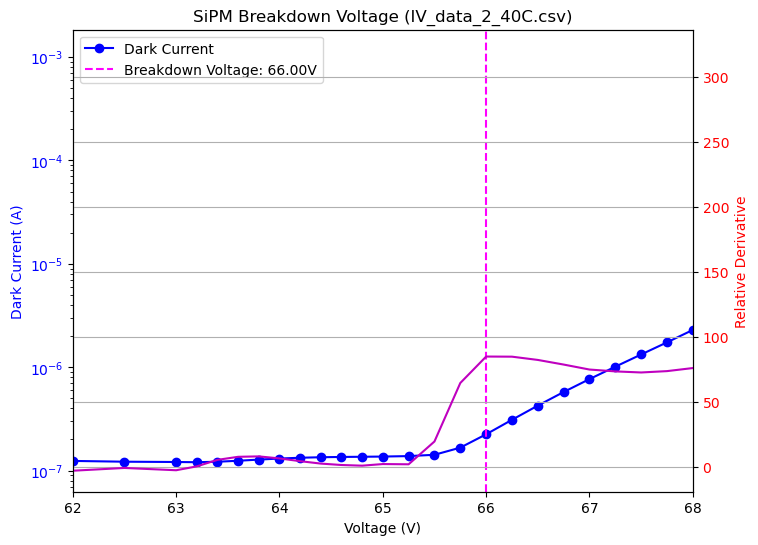

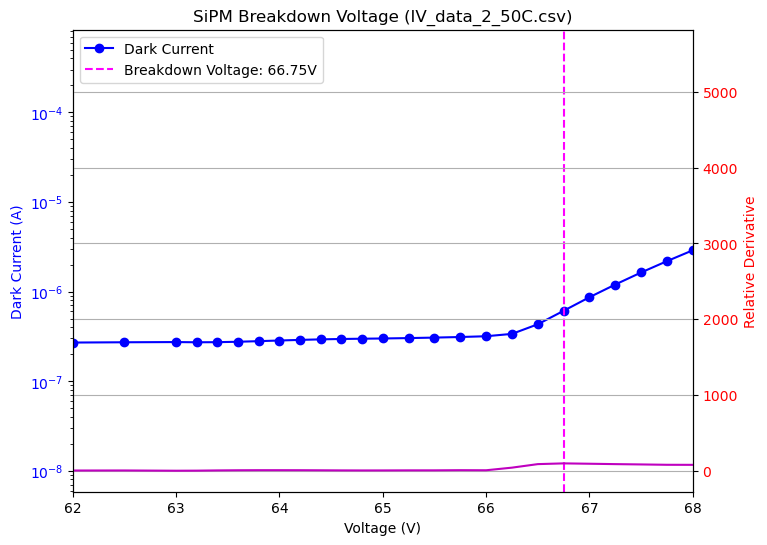

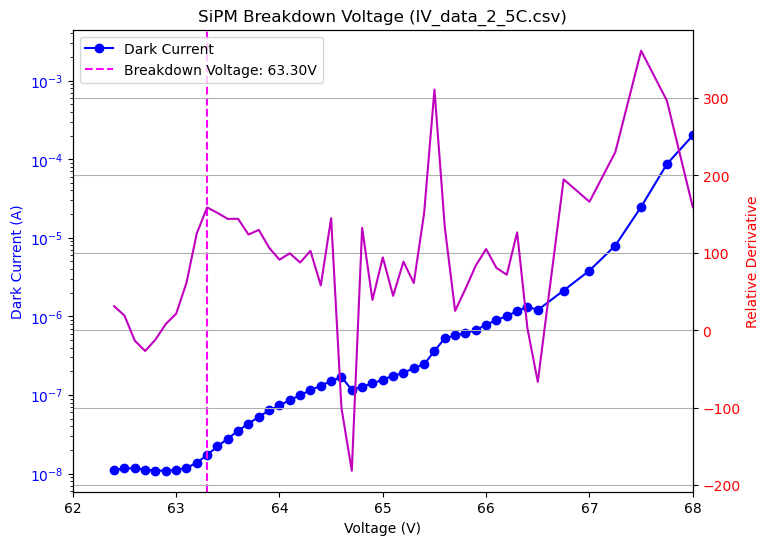

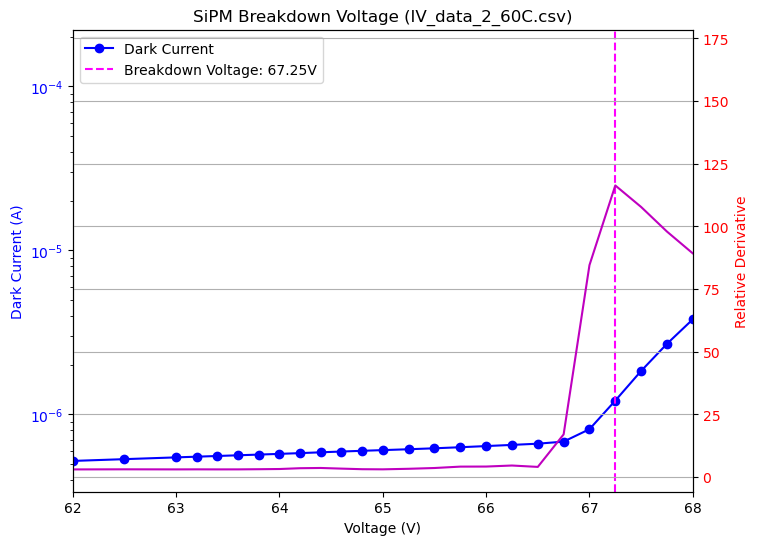


Extracting temperatures and breakdown voltages...

Breakdown Voltage Linear Fit Results (V_BD = a * Temp + b):
Slope (a): 0.0753 +/- 0.0042 V/°C
Intercept (b): 62.9477 +/- 0.1444 V
Voltage change per 0.1°C: 0.0075 +/- 0.0004 V


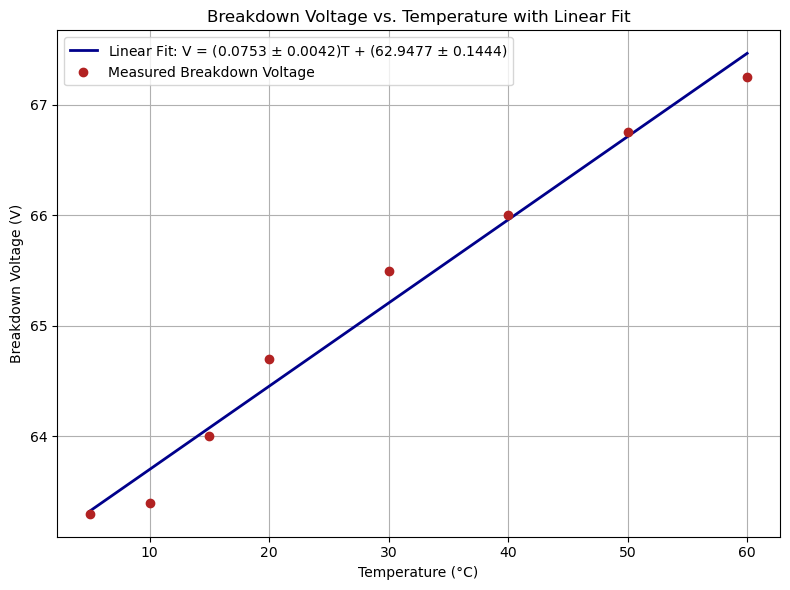


--- Analyzing DCR data and preparing for plotting ---

--- Plotting DCR data by threshold ---


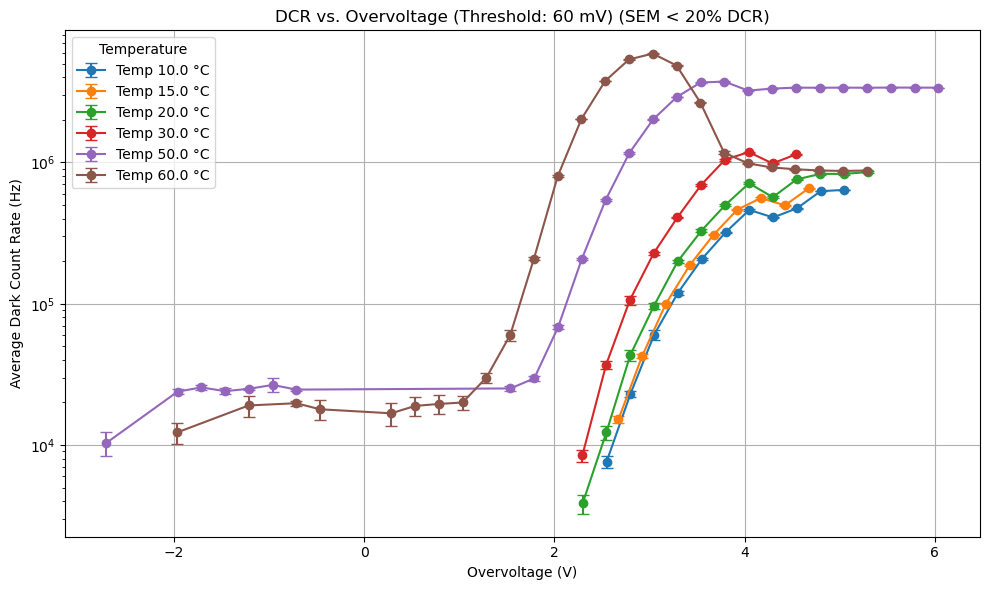

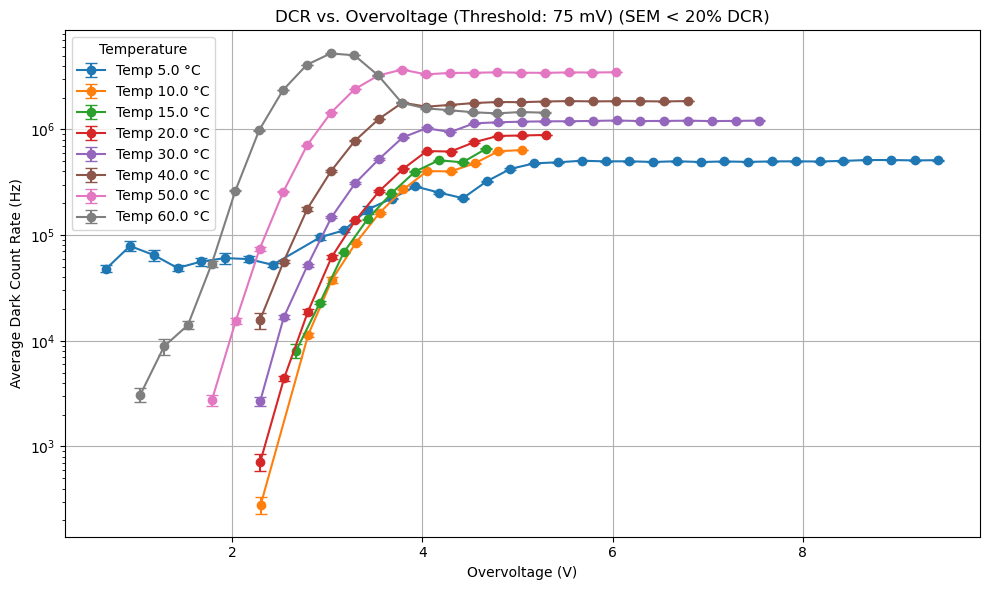

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # pandas is used in find_breakdown_voltage
import os
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks

# --- Functions from previous turn for V_BD determination and fit ---
# (Included here for a self-contained, runnable script.
# In your actual project, you might import these from a separate module.)

# Assuming iv_folder is defined globally or passed to the function
iv_folder = "IV_data_v2" # Make sure this path is correct for your setup

def find_breakdown_voltage(filename, folder=iv_folder, plot_range=2, max_voltage=68, min_voltage=62):
    """Find the first local max of the relative derivative under 68V and over a threshold."""
    data = pd.read_csv(os.path.join(folder, filename))

    voltages = data["Voltage (V)"].values
    currents = np.abs(data["Avg Current (A)"].values)

    # Spline interpolation
    spline = UnivariateSpline(voltages, currents, s=0, k=4)
    dI_dV = spline.derivative()(voltages)
    relative_derivative = (dI_dV / currents) * voltages

    # Focus on voltages under max_voltage and over min_voltage
    valid_indices = (voltages > min_voltage) & (voltages < max_voltage)
    rel_deriv = relative_derivative[valid_indices]
    v_filtered = voltages[valid_indices]

    # Find peaks in the relative derivative, height adjusted based on typical values for the OPA656U.
    peaks, _ = find_peaks(rel_deriv, height=60)

    breakdown_voltage = None
    if peaks.size > 0:
        breakdown_voltage = v_filtered[peaks[0]]

    if breakdown_voltage is None:
        print(f"Warning: No valid breakdown voltage found in {filename}")
        return filename, None

    # === Plot ===
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel("Voltage (V)")
    ax1.set_ylabel("Dark Current (A)", color="blue")
    ax1.plot(voltages, currents, 'bo-', label="Dark Current")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Relative Derivative", color="red")
    ax2.plot(voltages, relative_derivative, 'm-', label="Relative Derivative")
    ax2.tick_params(axis='y', labelcolor="red")

    ax1.axvline(breakdown_voltage, linestyle="--", color="magenta", label=f"Breakdown Voltage: {breakdown_voltage:.2f}V")
    plt.xlim(min_voltage, max_voltage)
    plt.title(f"SiPM Breakdown Voltage ({filename})")
    ax1.legend(loc="upper left")
    plt.grid(True)
    plt.show()

    return filename, breakdown_voltage

# --- Main script to get V_BD fit coefficients ---
if __name__ == '__main__':
    breakdown_voltages_data = []
    print("Processing IV files and finding breakdown voltages...")
    for file in sorted(os.listdir(iv_folder)):
        if file.endswith(".csv"):
            filename, breakdown_voltage = find_breakdown_voltage(file)
            if breakdown_voltage is not None:
                breakdown_voltages_data.append((filename, breakdown_voltage))

    temps_iv = []
    v_br = []

    print("\nExtracting temperatures and breakdown voltages...")
    for filename, voltage in breakdown_voltages_data:
        temp_str = filename.split("_")[-1].replace("C.csv", "")
        try:
            temp = float(temp_str)
            temps_iv.append(temp)
            v_br.append(voltage)
        except ValueError:
            print(f"Could not parse temperature from filename: {filename}. Skipping.")
            continue

    temps_iv = np.array(temps_iv)
    v_br = np.array(v_br)

    sort_indices = np.argsort(temps_iv)
    temps_iv = temps_iv[sort_indices]
    v_br = v_br[sort_indices]

    # Perform Linear Fit with Covariance for V_BD
    coeffs, covariance_matrix = np.polyfit(temps_iv, v_br, 1, cov=True)
    slope_a = coeffs[0]
    intercept_b = coeffs[1]
    std_error_a = np.sqrt(covariance_matrix[0, 0])
    std_error_b = np.sqrt(covariance_matrix[1, 1])

    print(f"\nBreakdown Voltage Linear Fit Results (V_BD = a * Temp + b):")
    print(f"Slope (a): {slope_a:.4f} +/- {std_error_a:.4f} V/°C")
    print(f"Intercept (b): {intercept_b:.4f} +/- {std_error_b:.4f} V")

    voltage_change_per_0_1C = slope_a * 0.1
    std_error_voltage_change_per_0_1C = std_error_a * 0.1
    print(f"Voltage change per 0.1°C: {voltage_change_per_0_1C:.4f} +/- {std_error_voltage_change_per_0_1C:.4f} V")

    temp_fit = np.linspace(temps_iv.min(), temps_iv.max(), 100)
    v_br_fit = slope_a * temp_fit + intercept_b

    plt.figure(figsize=(8, 6))
    plt.errorbar(temps_iv, v_br, yerr=None, fmt='o', color='firebrick', markersize=6, label="Measured Breakdown Voltage")
    plt.plot(temp_fit, v_br_fit, '-', color='darkblue', linewidth=2, label=f"Linear Fit: V = ({slope_a:.4f} $\\pm$ {std_error_a:.4f})T + ({intercept_b:.4f} $\\pm$ {std_error_b:.4f})")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Breakdown Voltage (V)")
    plt.title("Breakdown Voltage vs. Temperature with Linear Fit")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Refactored DCR analysis function (data loading and overvoltage calculation) ---
def analyze_dcr_from_csv(csv_file, vbd_slope, vbd_intercept):
    """
    Analyzes DCR data from a CSV file, calculates overvoltage for all data points.

    Args:
        csv_file (str): Path to the CSV file.
        vbd_slope (float): Slope 'a' from the V_BD vs. Temperature linear fit.
        vbd_intercept (float): Intercept 'b' from the V_BD vs. Temperature linear fit.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              'temperature', 'voltage', 'dcr', 'sem', 'threshold', and 'overvoltage'.
    """
    data_points = []

    with open(csv_file, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            try:
                temperature = float(row['Temperature (°C)'])
                voltage = float(row['Voltage (V)'])
                dcr = float(row['Average DCR (Hz)'])
                sem = float(row['SEM (Hz)'])
                threshold = float(row['Threshold (mV)'])

                data_points.append({
                    'temperature': temperature,
                    'voltage': voltage,
                    'dcr': dcr,
                    'sem': sem,
                    'threshold': threshold
                })
            except ValueError as e:
                print(f"Error reading row: {row}. Skipping. Error: {e}")
                continue

    if not data_points:
        print("No valid data found in the CSV file.")
        return []

    # Calculate overvoltage for each data point
    for dp in data_points:
        v_bd_at_temp = vbd_slope * dp['temperature'] + vbd_intercept
        dp['overvoltage'] = dp['voltage'] - v_bd_at_temp

    return data_points

# --- New plotting function ---
def plot_dcr_data_by_threshold(data_points, thresholds_to_plot=None):
    """
    Plots DCR vs. Overvoltage and DCR vs. Temperature for specified thresholds.

    Args:
        data_points (list): List of dictionaries containing DCR data with overvoltage.
        thresholds_to_plot (list, optional): A list of threshold values (in mV)
                                             to plot. If None, plots all unique thresholds.
    """
    if not data_points:
        print("No data points provided for plotting.")
        return

    # Get all unique thresholds present in the data
    all_unique_thresholds = sorted(list(set(dp['threshold'] for dp in data_points)))

    # Determine which thresholds to actually plot
    if thresholds_to_plot is None:
        selected_thresholds = all_unique_thresholds
    else:
        selected_thresholds = sorted([t for t in thresholds_to_plot if t in all_unique_thresholds])
        if not selected_thresholds:
            print(f"None of the specified thresholds {thresholds_to_plot} found in the data.")
            return

    for current_threshold in selected_thresholds:
        # Filter data for the current threshold
        threshold_data = [dp for dp in data_points if dp['threshold'] == current_threshold]
        if not threshold_data:
            continue # Skip if no data for this threshold

        # --- Plot DCR vs. Overvoltage for the current threshold ---
        plt.figure(figsize=(10, 6))
        
        temperatures_present = sorted(list(set(dp['temperature'] for dp in threshold_data)))

        for temp in temperatures_present:
            # Filter data points for the current temperature AND error < 20%
            temp_data_filtered = sorted(
                [dp for dp in threshold_data if dp['temperature'] == temp and dp['sem'] < 0.20 * dp['dcr']],
                key=lambda x: x['overvoltage']
            )
            overvoltages_at_temp = [dp['overvoltage'] for dp in temp_data_filtered]
            dcr_at_temp = [dp['dcr'] for dp in temp_data_filtered]
            sem_at_temp = [dp['sem'] for dp in temp_data_filtered]

            if overvoltages_at_temp:
                plt.errorbar(overvoltages_at_temp, dcr_at_temp, yerr=sem_at_temp, fmt='o-', label=f'Temp {temp:.1f} °C', capsize=4)

        title_suffix = f' (SEM < 20% DCR)'
        plt.xlabel('Overvoltage (V)')
        plt.ylabel('Average Dark Count Rate (Hz)')
        plt.title(f'DCR vs. Overvoltage (Threshold: {current_threshold} mV){title_suffix}')
        plt.grid(True)
        plt.yscale('log')
        plt.legend(title='Temperature', loc='best')
        plt.tight_layout()
        plt.show()

    

# --- Example Usage ---
if __name__ == '__main__':
    csv_file_path = 'dcr_vs_voltage2.csv'  # Replace with your actual DCR CSV file path
    
    print("\n--- Analyzing DCR data and preparing for plotting ---")
    # analyze_dcr_from_csv now returns the processed data points for all thresholds
    all_dcr_data = analyze_dcr_from_csv(csv_file_path, slope_a, intercept_b)
    
    print("\n--- Plotting DCR data by threshold ---")
    # Option 1: Plot for all unique thresholds found in the data (if threshold_mv_filter was None)
    # This will generate a separate set of DCR vs OV and DCR vs Temp plots for each threshold.
    #plot_dcr_data_by_threshold(all_dcr_data)
    
    # Option 2: Plot only for specific thresholds (e.g., 60 mV and 75 mV)
    # This will generate plots only for the thresholds specified in the list.
    plot_dcr_data_by_threshold(all_dcr_data, thresholds_to_plot=[60, 75])
    
    # Option 3: Plot for a single specific threshold (e.g., 60 mV)
    # plot_dcr_data_by_threshold(all_dcr_data, thresholds_to_plot=[60])